In [29]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Import libraries
from pathlib import Path
import numpy as np
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import datetime
now = datetime.datetime.now

import csv
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchsummary import summary
import torchvision
from torchvision import transforms
import copy

In [31]:
import os
from functools import partial
from itertools import product
from collections import OrderedDict
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from torchvision import datasets, transforms as T
from sklearn.model_selection import train_test_split, KFold
import natsort
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from os import listdir
import pandas
from pandas import DataFrame
import tensorflow as tf

In [32]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [33]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done


In [34]:
# Import PGD attack
import cleverhans

from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

# Dataset Loading

In [35]:
# Download the dataset
!wget https://www.webpages.uidaho.edu/vakanski/Codes_Data/LFW-dataset.zip

--2025-02-14 00:36:31--  https://www.webpages.uidaho.edu/vakanski/Codes_Data/LFW-dataset.zip
Resolving www.webpages.uidaho.edu (www.webpages.uidaho.edu)... 129.101.105.230
Connecting to www.webpages.uidaho.edu (www.webpages.uidaho.edu)|129.101.105.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12467105 (12M) [application/x-zip-compressed]
Saving to: ‘LFW-dataset.zip.1’

LFW-dataset.zip.1   100%[===================>]  11.89M  4.01MB/s    in 3.0s    

2025-02-14 00:36:35 (4.01 MB/s) - ‘LFW-dataset.zip.1’ saved [12467105/12467105]



In [36]:
# Uncompress the dataset
!unzip -uq 'LFW-dataset.zip' -d 'sample_data/'

In [37]:
# Define a function for loading the dataset
class MyDataset(Dataset):
    def __init__(self, root_dir, transform, split):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, split)
        self.labels_file = np.genfromtxt(root_dir + split + "_labels.csv", delimiter=',', dtype=np.int32)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file[idx]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [38]:
# Define the transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224 x 224 pixels
    transforms.ToTensor(),  # Convert the images to a PyTorch tensor
])

In [39]:
# Download the train, test, and validation datasets
train_dataset = MyDataset(root_dir='sample_data/LFW-dataset/', transform=transform, split='train')
test_dataset = MyDataset(root_dir='sample_data/LFW-dataset/', transform=transform, split='test')
val_dataset = MyDataset(root_dir='sample_data/LFW-dataset/', transform=transform, split='validation')

In [40]:
# Check the datasets
print('Train dataset length:', len(train_dataset))
print('Test dataset length:', len(test_dataset))
print('Validation dataset length:', len(val_dataset))


Train dataset length: 3043
Test dataset length: 1049
Validation dataset length: 1021


In [41]:
# Create dataloaders to iterate over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [42]:
# Read the names of the celebrities in the dataset (there are 62 celebrities)
name_list = []
with open("sample_data/LFW-dataset/name_list.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        name_list.append(row[1])

In [43]:
name_list

['Gloria_Macapagal_Arroyo',
 'Jennifer_Capriati',
 'Laura_Bush',
 'Winona_Ryder',
 'Tiger_Woods',
 'Hugo_Chavez',
 'John_Negroponte',
 'George_W_Bush',
 'Roh_Moo-hyun',
 'Paul_Bremer',
 'George_Robertson',
 'Tom_Daschle',
 'Ricardo_Lagos',
 'Jennifer_Lopez',
 'Jose_Maria_Aznar',
 'Silvio_Berlusconi',
 'Vicente_Fox',
 'Jennifer_Aniston',
 'Gerhard_Schroeder',
 'David_Beckham',
 'Kofi_Annan',
 'Igor_Ivanov',
 'Jiang_Zemin',
 'Mahmoud_Abbas',
 'Pete_Sampras',
 'Guillermo_Coria',
 'Donald_Rumsfeld',
 'Megawati_Sukarnoputri',
 'Jeremy_Greenstock',
 'Junichiro_Koizumi',
 'Jack_Straw',
 'Rudolph_Giuliani',
 'Jacques_Chirac',
 'Saddam_Hussein',
 'John_Ashcroft',
 'Lindsay_Davenport',
 'Naomi_Watts',
 'Lleyton_Hewitt',
 'Hamid_Karzai',
 'Tom_Ridge',
 'Recep_Tayyip_Erdogan',
 'Tony_Blair',
 'Hans_Blix',
 'Jean_Chretien',
 'Nestor_Kirchner',
 'Gray_Davis',
 'Michael_Bloomberg',
 'Luiz_Inacio_Lula_da_Silva',
 'Juan_Carlos_Ferrero',
 'Vladimir_Putin',
 'Serena_Williams',
 'Alejandro_Toledo',
 'Alva

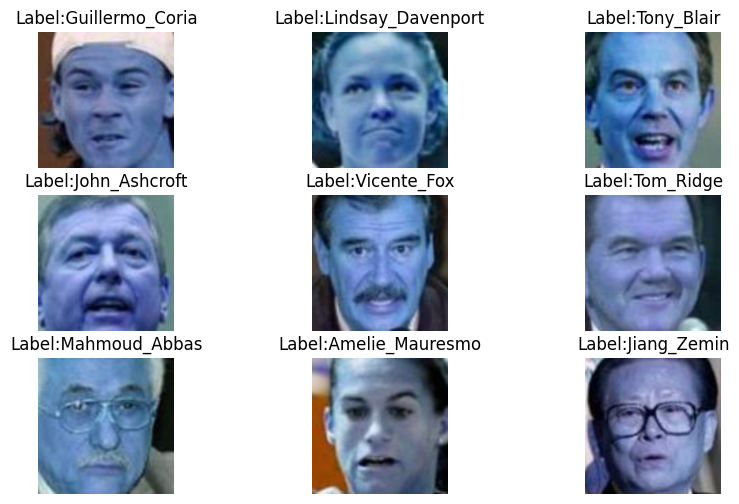

In [44]:
# Plot several images and labels
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str(name_list[labels[0]]))
    plt.axis('off')

### Vision Transformer

In [45]:
!pip -q install vit_pytorch linformer

In [46]:
from vit_pytorch.efficient import ViT
from linformer import Linformer

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [48]:
efficient_transformer = Linformer(
    dim=128, # dimension of the attention heads
    seq_len=49+1,  # length of input sequences: 7x7 patches + 1 class token
    depth=12, # number of stacked encoder blocks in the model
    heads=8, # number of attention heads
    k=64  # reduce the input dimension for efficiency
)

In [49]:
model = ViT(
    dim=128, # dimension of the attention heads
    image_size=224, # resolution of images
    patch_size=32, # size of image patches
    num_classes=62, # number of classes
    transformer=efficient_transformer, # the transformer backbone
    channels=3, # number of channels in images
)

In [50]:
model.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

In [51]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [52]:
epochs = 20

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

In [53]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_dataloader)
            epoch_val_loss += val_loss / len(val_dataloader)


    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(epoch_accuracy)
    training_loss_plot.append(epoch_loss)
    val_accuracy_plot.append(epoch_val_accuracy)
    val_loss_plot.append(epoch_val_loss)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.7997 - acc: 0.1629 - val_loss : 3.7118 - val_acc: 0.1719



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.6999 - acc: 0.1732 - val_loss : 3.6730 - val_acc: 0.1719



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 3 - loss : 3.6001 - acc: 0.1809 - val_loss : 3.4720 - val_acc: 0.1871



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 4 - loss : 3.1988 - acc: 0.2450 - val_loss : 2.8017 - val_acc: 0.3209



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.5188 - acc: 0.4181 - val_loss : 2.3082 - val_acc: 0.4724



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.9547 - acc: 0.5817 - val_loss : 1.9723 - val_acc: 0.6044



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.5213 - acc: 0.7246 - val_loss : 1.6253 - val_acc: 0.6756



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.1490 - acc: 0.8261 - val_loss : 1.3951 - val_acc: 0.7246



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.8399 - acc: 0.8996 - val_loss : 1.2176 - val_acc: 0.7880



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6100 - acc: 0.9485 - val_loss : 1.0595 - val_acc: 0.8173



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.4407 - acc: 0.9711 - val_loss : 0.9403 - val_acc: 0.8466



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3091 - acc: 0.9889 - val_loss : 0.8565 - val_acc: 0.8427



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.2185 - acc: 0.9971 - val_loss : 0.7917 - val_acc: 0.8527



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.1561 - acc: 0.9997 - val_loss : 0.7539 - val_acc: 0.8596



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.1179 - acc: 1.0000 - val_loss : 0.7302 - val_acc: 0.8604



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0937 - acc: 1.0000 - val_loss : 0.7041 - val_acc: 0.8565



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0756 - acc: 1.0000 - val_loss : 0.6893 - val_acc: 0.8594



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0642 - acc: 1.0000 - val_loss : 0.6817 - val_acc: 0.8585



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0555 - acc: 1.0000 - val_loss : 0.6704 - val_acc: 0.8566



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0486 - acc: 1.0000 - val_loss : 0.6715 - val_acc: 0.8556



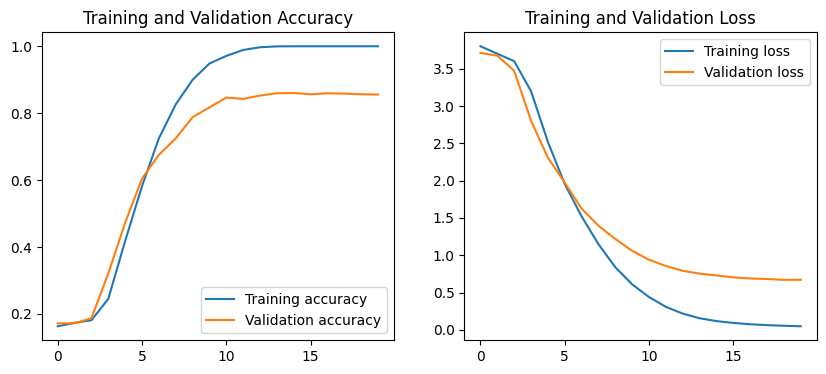

In [58]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot([x.cpu().numpy() for x in training_accuracy_plot])
plt.plot([x.cpu().numpy() for x in val_accuracy_plot])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot([x.cpu().detach().numpy() for x in training_loss_plot])
plt.plot([x.cpu().detach().numpy() for x in val_loss_plot])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

In [59]:
# test the model
model.eval()  # it disables dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 84.36606291706387 %


### Model Report

| Model | Train Set | Validation Set | Test Set |
| --- | --- | --- | ---|
| ViT | 100 | 85.56 | 84.366 |

### Transferability Attack

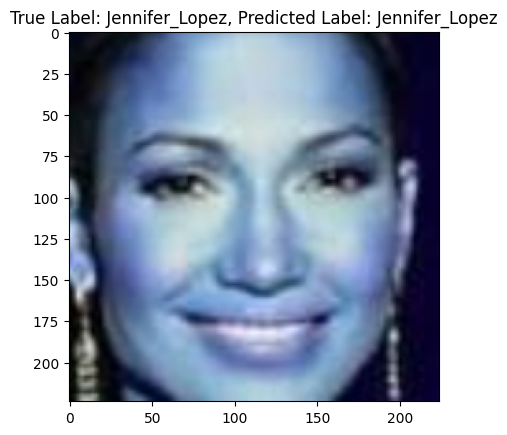

In [68]:
from torch.utils.data import Subset

sample_idx = 343

# Create a Subset with only the desired sample
subset = Subset(test_dataset, [sample_idx])

# Create a DataLoader for the subset with batch_size=1
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Get the sample image and label
sample_image, sample_true_label = next(iter(subset_loader))

# Move the sample image to the device (CPU or GPU)
sample_image = sample_image.to(device)

# Get the model's prediction
model.eval()
with torch.no_grad():
    output = model(sample_image)  # No need to unsqueeze as batch_size is 1
    sample_pred_label = output.argmax(dim=1).item()

# Print the sample image, prediction, and true label (optional)
plt.imshow(sample_image.cpu().squeeze().permute(1, 2, 0))  # Move to CPU, squeeze, and permute dimensions for display
plt.title(f"True Label: {name_list[sample_true_label.item()]}, Predicted Label: {name_list[sample_pred_label]}")
plt.show()

# Save the sample image, prediction, and true label
torchvision.utils.save_image(sample_image.cpu(), f"sample_image_{sample_idx}.png")
with open(f"sample_info_{sample_idx}.txt", "w") as f:
    f.write(f"True Label: {name_list[sample_true_label.item()]}\n")
    f.write(f"Predicted Label: {name_list[sample_pred_label]}\n")

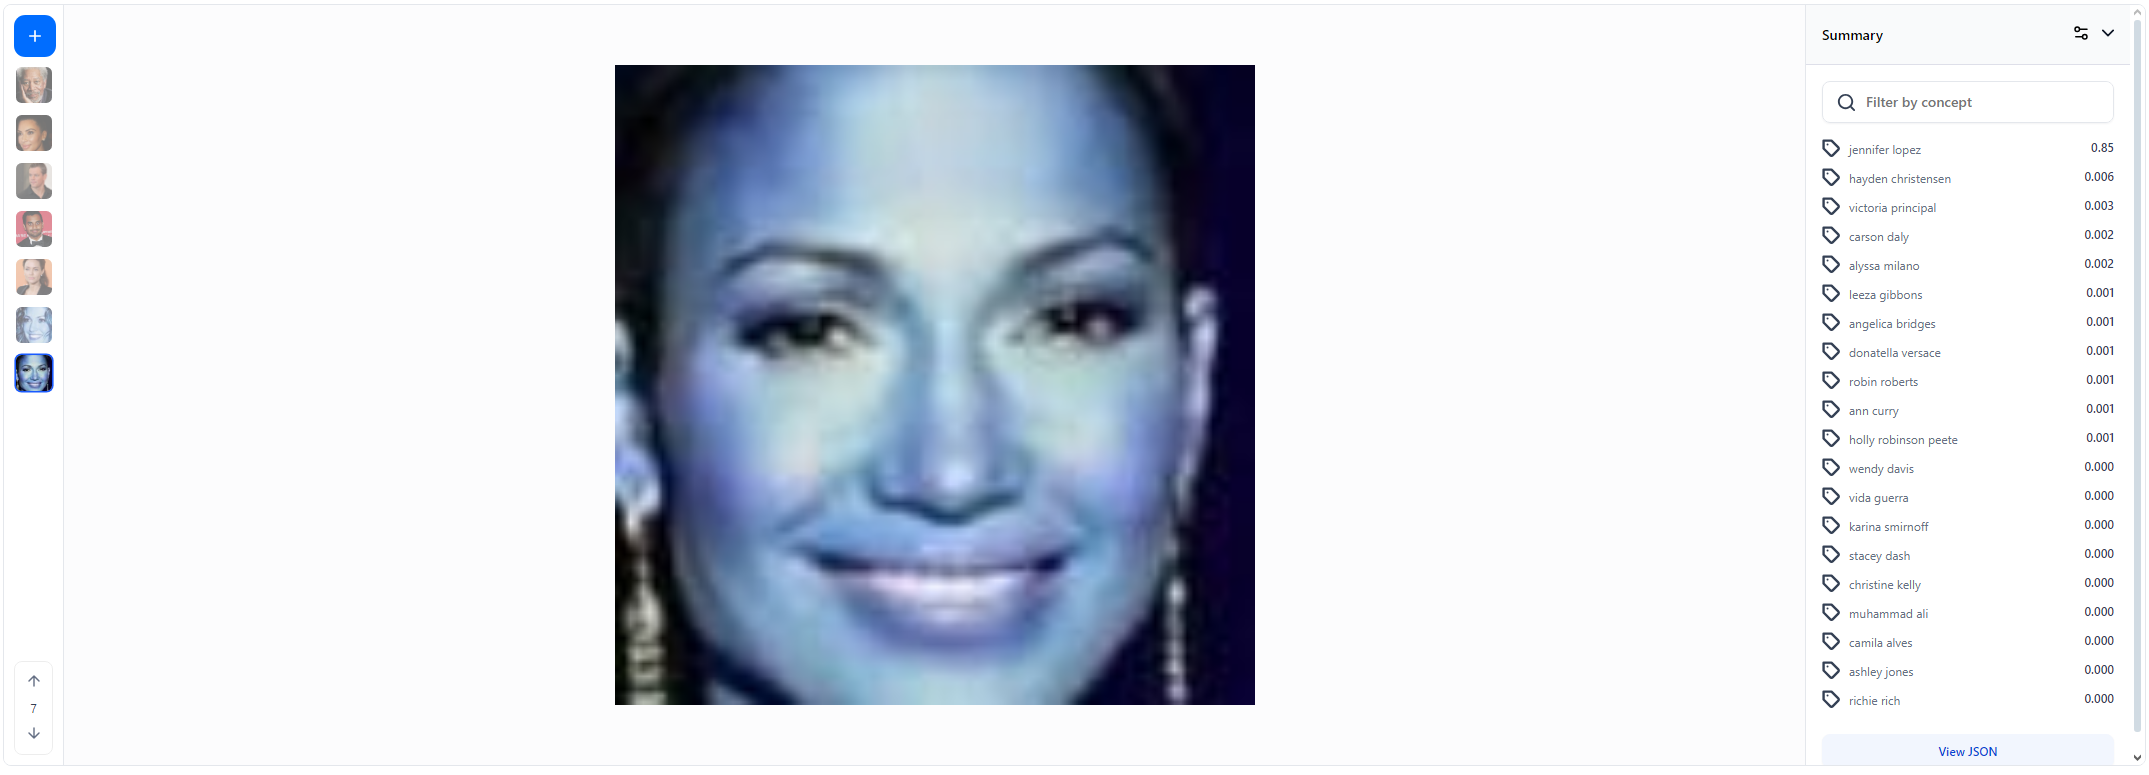

In [80]:
def model_fn(x):
    return model(x)  # Assuming 'model' is your ViT model instance

epsilon = 60./255
sub_dataset = Subset(test_dataset, [343])
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_image = projected_gradient_descent(model_fn=model_fn, x=images, eps=epsilon, eps_iter=2.5*epsilon/60, nb_iter=60, norm=np.inf)

import torchvision.transforms.functional as TF
from torchvision.utils import save_image
TF.to_pil_image(adversarial_image[0].cpu()).save('im1.jpg')

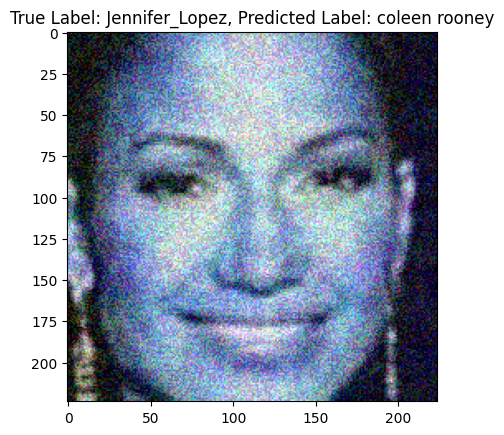

In [85]:
# Print the sample image, prediction, and true label (optional)
plt.imshow(adversarial_image[0].detach().cpu().squeeze().permute(1, 2, 0))  # Detach before converting to NumPy
plt.title(f"True Label: {name_list[sample_true_label.item()]}, Predicted Label: coleen rooney")
plt.show()

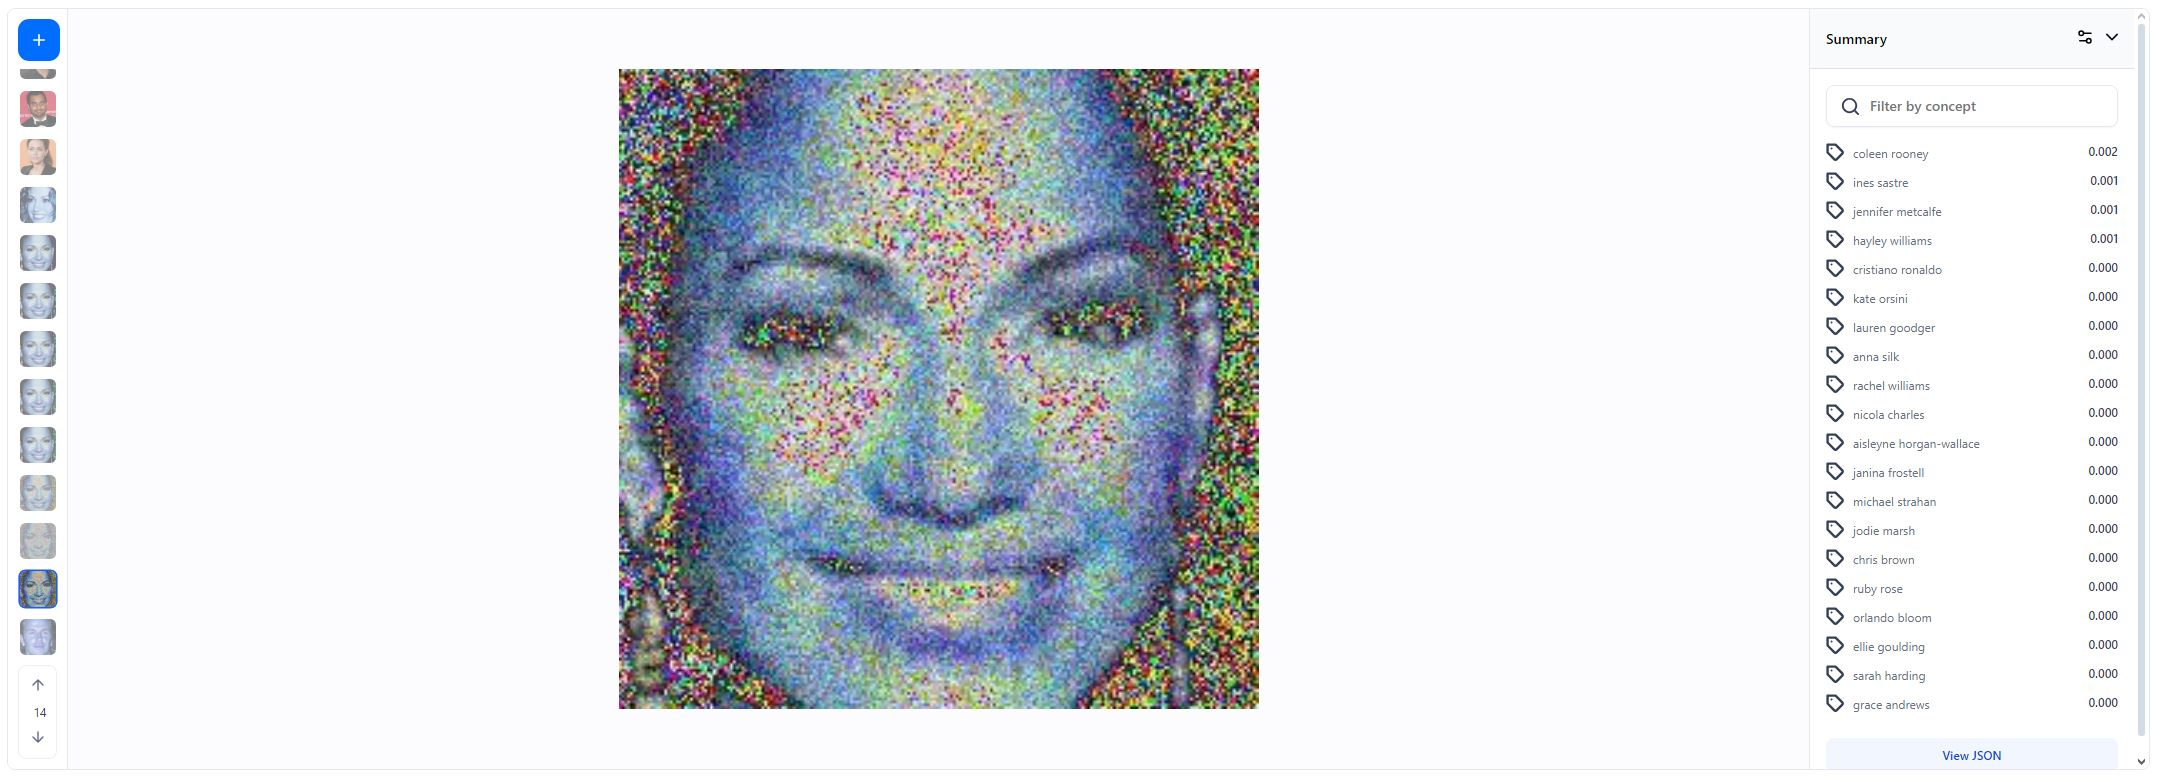

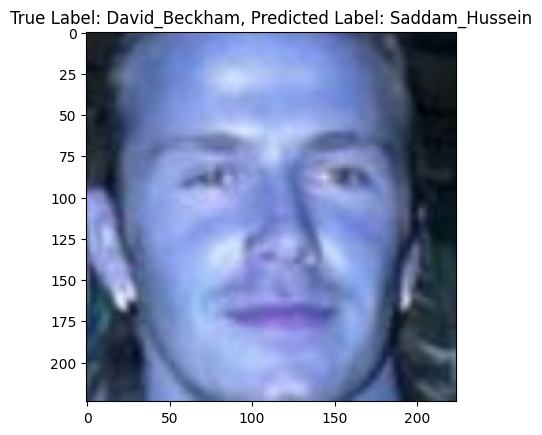

In [86]:
sample_idx = 442

# Create a Subset with only the desired sample
subset = Subset(test_dataset, [sample_idx])

# Create a DataLoader for the subset with batch_size=1
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Get the sample image and label
sample_image, sample_true_label = next(iter(subset_loader))

# Move the sample image to the device (CPU or GPU)
sample_image = sample_image.to(device)

# Get the model's prediction
model.eval()
with torch.no_grad():
    output = model(sample_image)  # No need to unsqueeze as batch_size is 1
    sample_pred_label = output.argmax(dim=1).item()

# Print the sample image, prediction, and true label (optional)
plt.imshow(sample_image.cpu().squeeze().permute(1, 2, 0))  # Move to CPU, squeeze, and permute dimensions for display
plt.title(f"True Label: {name_list[sample_true_label.item()]}, Predicted Label: {name_list[sample_pred_label]}")
plt.show()

# Save the sample image, prediction, and true label
torchvision.utils.save_image(sample_image.cpu(), f"sample_image_{sample_idx}.png")
with open(f"sample_info_{sample_idx}.txt", "w") as f:
    f.write(f"True Label: {name_list[sample_true_label.item()]}\n")
    f.write(f"Predicted Label: {name_list[sample_pred_label]}\n")

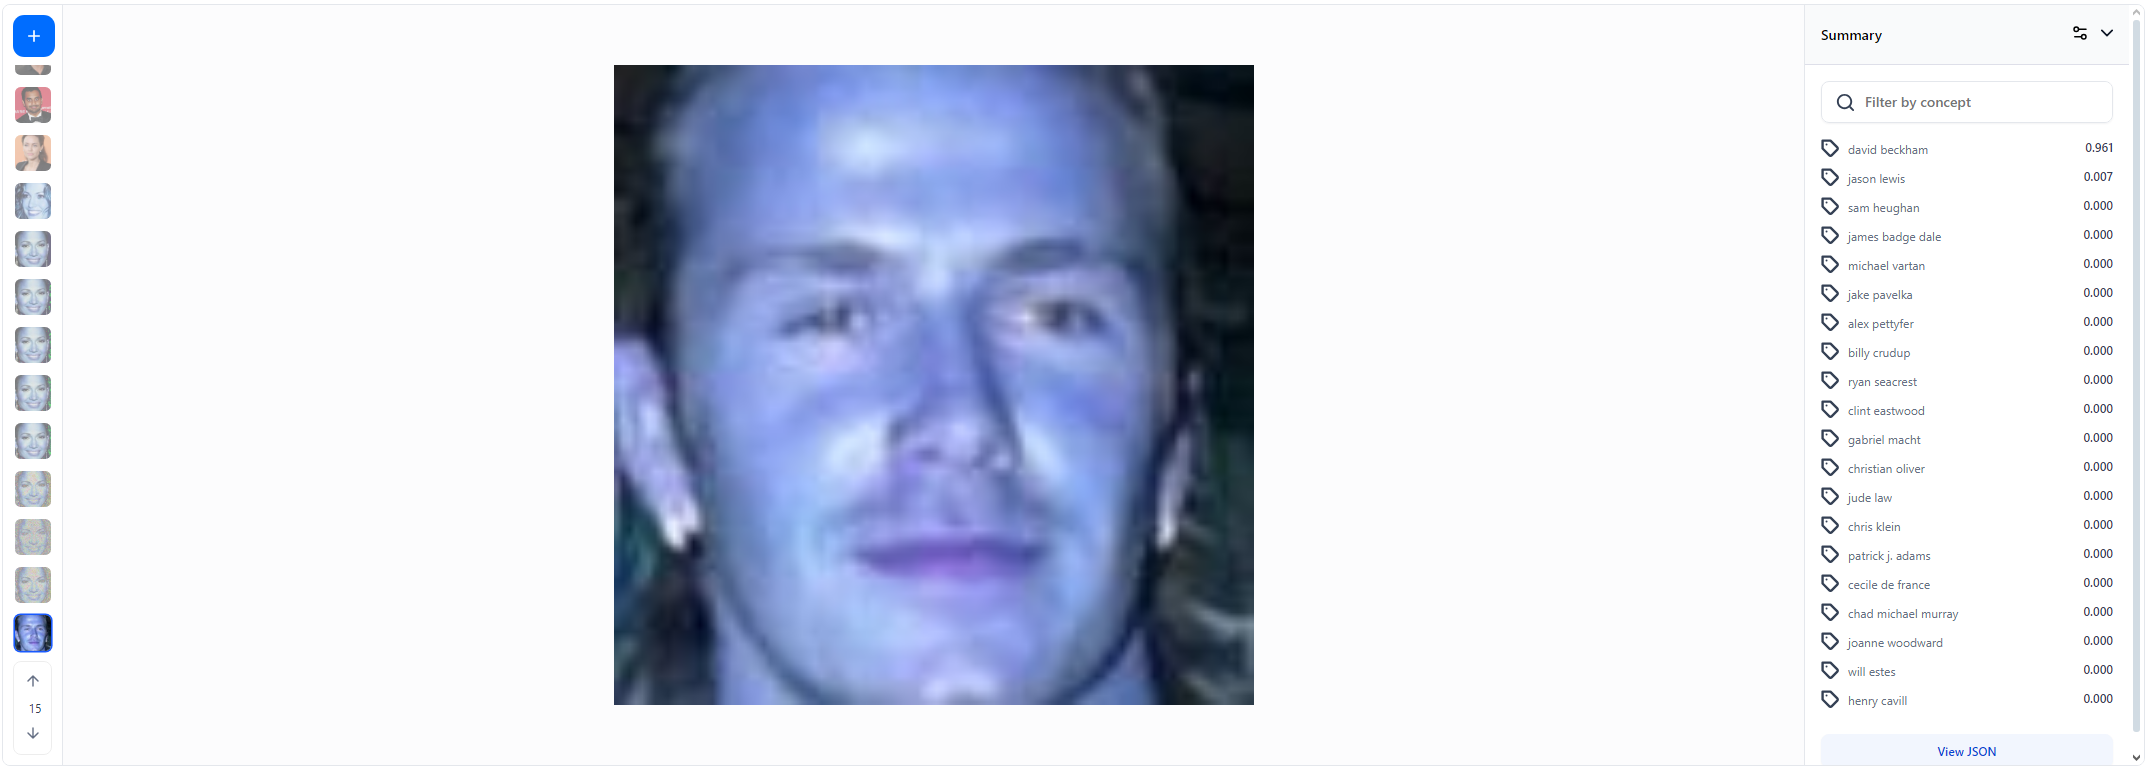

In [93]:
def model_fn(x):
    return model(x)  # Assuming 'model' is your ViT model instance

epsilon = 35./255
sub_dataset = Subset(test_dataset, [442])
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_image = projected_gradient_descent(model_fn=model_fn, x=images, eps=epsilon, eps_iter=2.5*epsilon/60, nb_iter=60, norm=np.inf)

import torchvision.transforms.functional as TF
from torchvision.utils import save_image
TF.to_pil_image(adversarial_image[0].cpu()).save('im2.jpg')

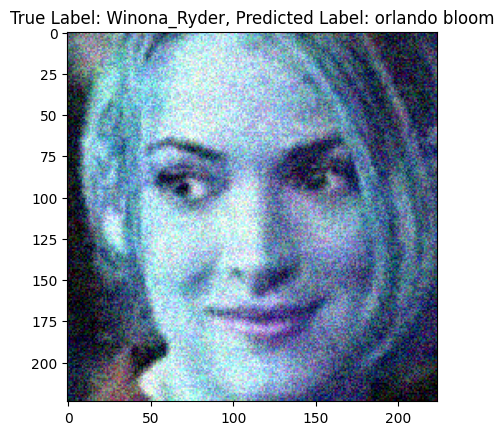

In [109]:
# Print the sample image, prediction, and true label (optional)
plt.imshow(adversarial_image[0].detach().cpu().squeeze().permute(1, 2, 0))  # Detach before converting to NumPy
plt.title(f"True Label: {name_list[sample_true_label.item()]}, Predicted Label: orlando bloom")
plt.show()

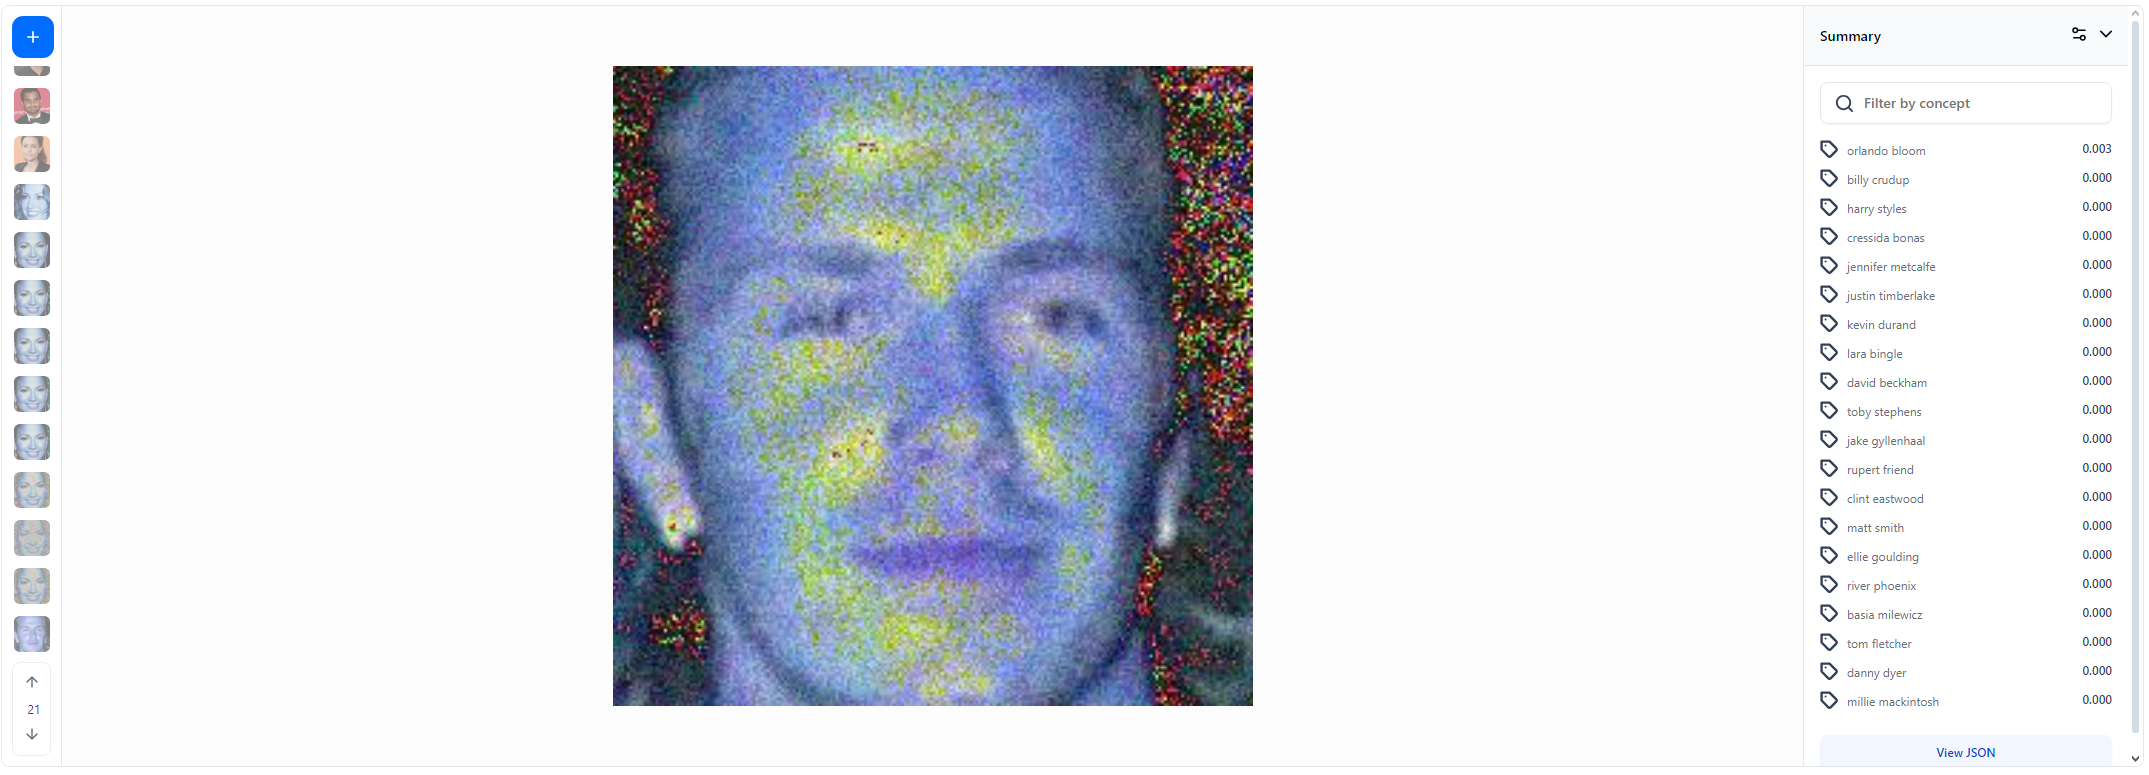

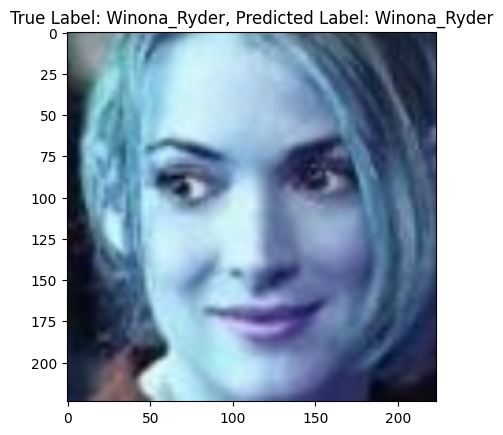

In [95]:
sample_idx = 53

# Create a Subset with only the desired sample
subset = Subset(test_dataset, [sample_idx])

# Create a DataLoader for the subset with batch_size=1
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Get the sample image and label
sample_image, sample_true_label = next(iter(subset_loader))

# Move the sample image to the device (CPU or GPU)
sample_image = sample_image.to(device)

# Get the model's prediction
model.eval()
with torch.no_grad():
    output = model(sample_image)  # No need to unsqueeze as batch_size is 1
    sample_pred_label = output.argmax(dim=1).item()

# Print the sample image, prediction, and true label (optional)
plt.imshow(sample_image.cpu().squeeze().permute(1, 2, 0))  # Move to CPU, squeeze, and permute dimensions for display
plt.title(f"True Label: {name_list[sample_true_label.item()]}, Predicted Label: {name_list[sample_pred_label]}")
plt.show()

# Save the sample image, prediction, and true label
torchvision.utils.save_image(sample_image.cpu(), f"sample_image_{sample_idx}.png")
with open(f"sample_info_{sample_idx}.txt", "w") as f:
    f.write(f"True Label: {name_list[sample_true_label.item()]}\n")
    f.write(f"Predicted Label: {name_list[sample_pred_label]}\n")

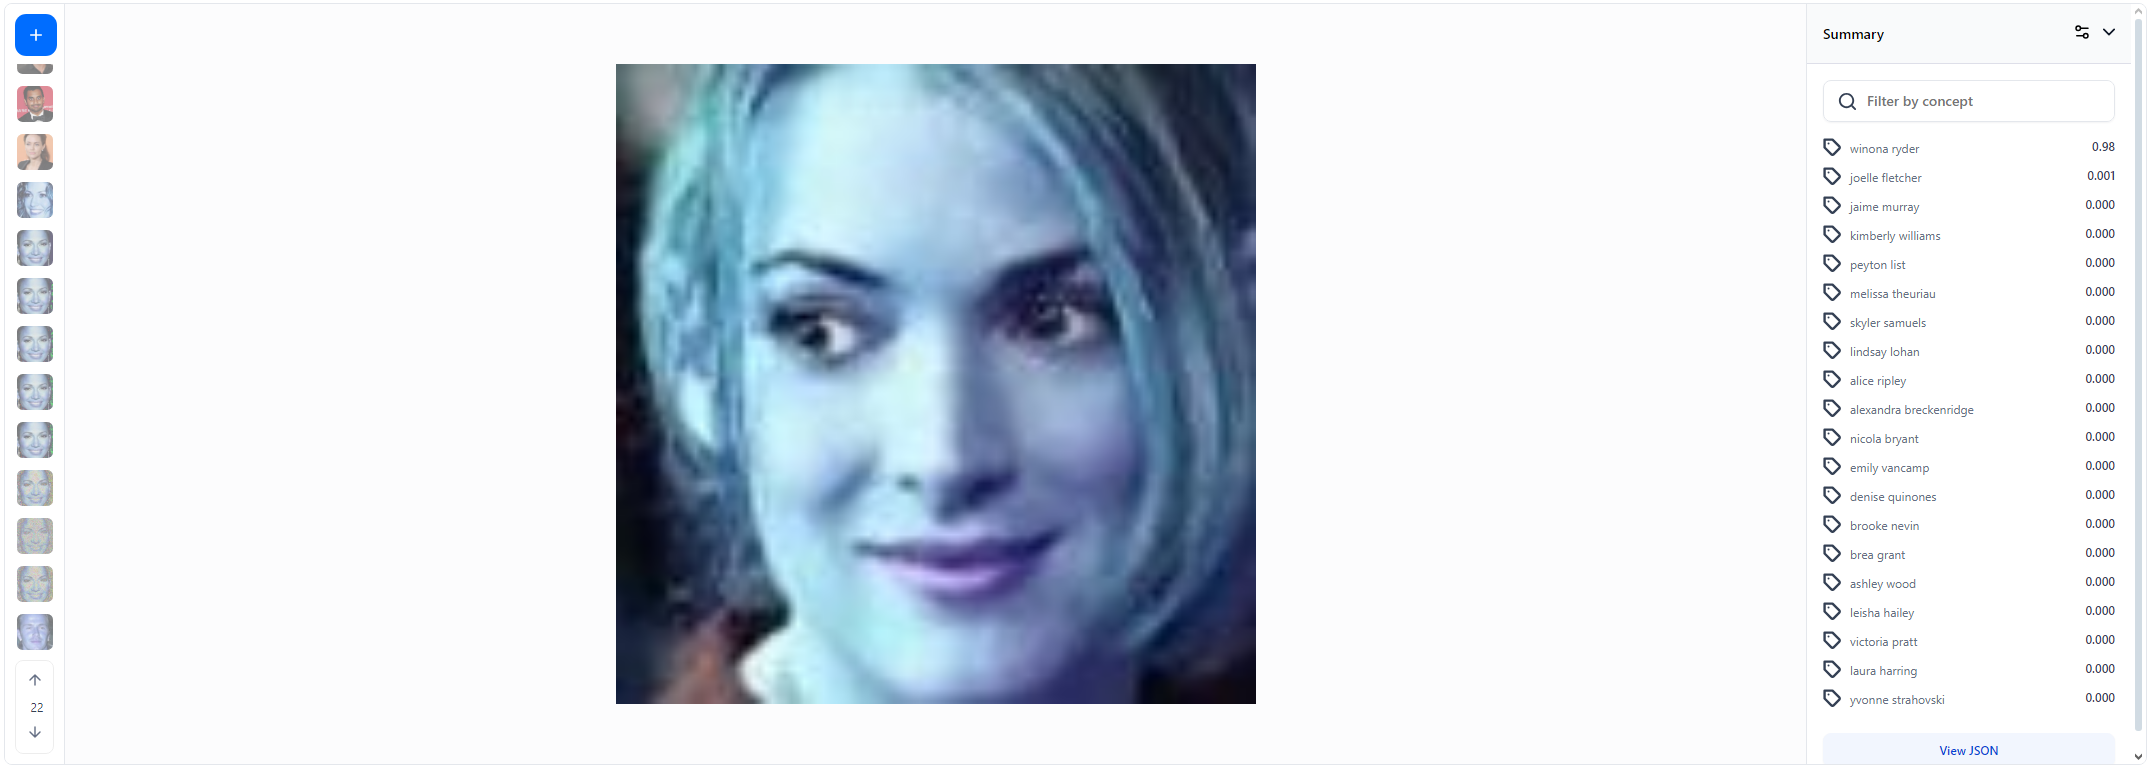

In [105]:
def model_fn(x):
    return model(x)  # Assuming 'model' is your ViT model instance

epsilon = 50./255
sub_dataset = Subset(test_dataset, [53])
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_image = projected_gradient_descent(model_fn=model_fn, x=images, eps=epsilon, eps_iter=2.5*epsilon/60, nb_iter=60, norm=np.inf)

import torchvision.transforms.functional as TF
from torchvision.utils import save_image
TF.to_pil_image(adversarial_image[0].cpu()).save('im3.jpg')

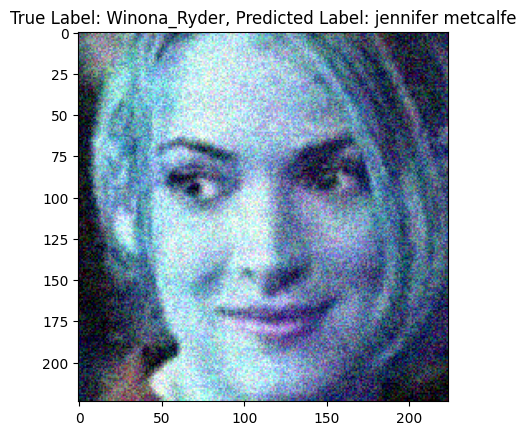

In [108]:
# Print the sample image, prediction, and true label (optional)
plt.imshow(adversarial_image[0].detach().cpu().squeeze().permute(1, 2, 0))  # Detach before converting to NumPy
plt.title(f"True Label: {name_list[sample_true_label.item()]}, Predicted Label: jennifer metcalfe")
plt.show()

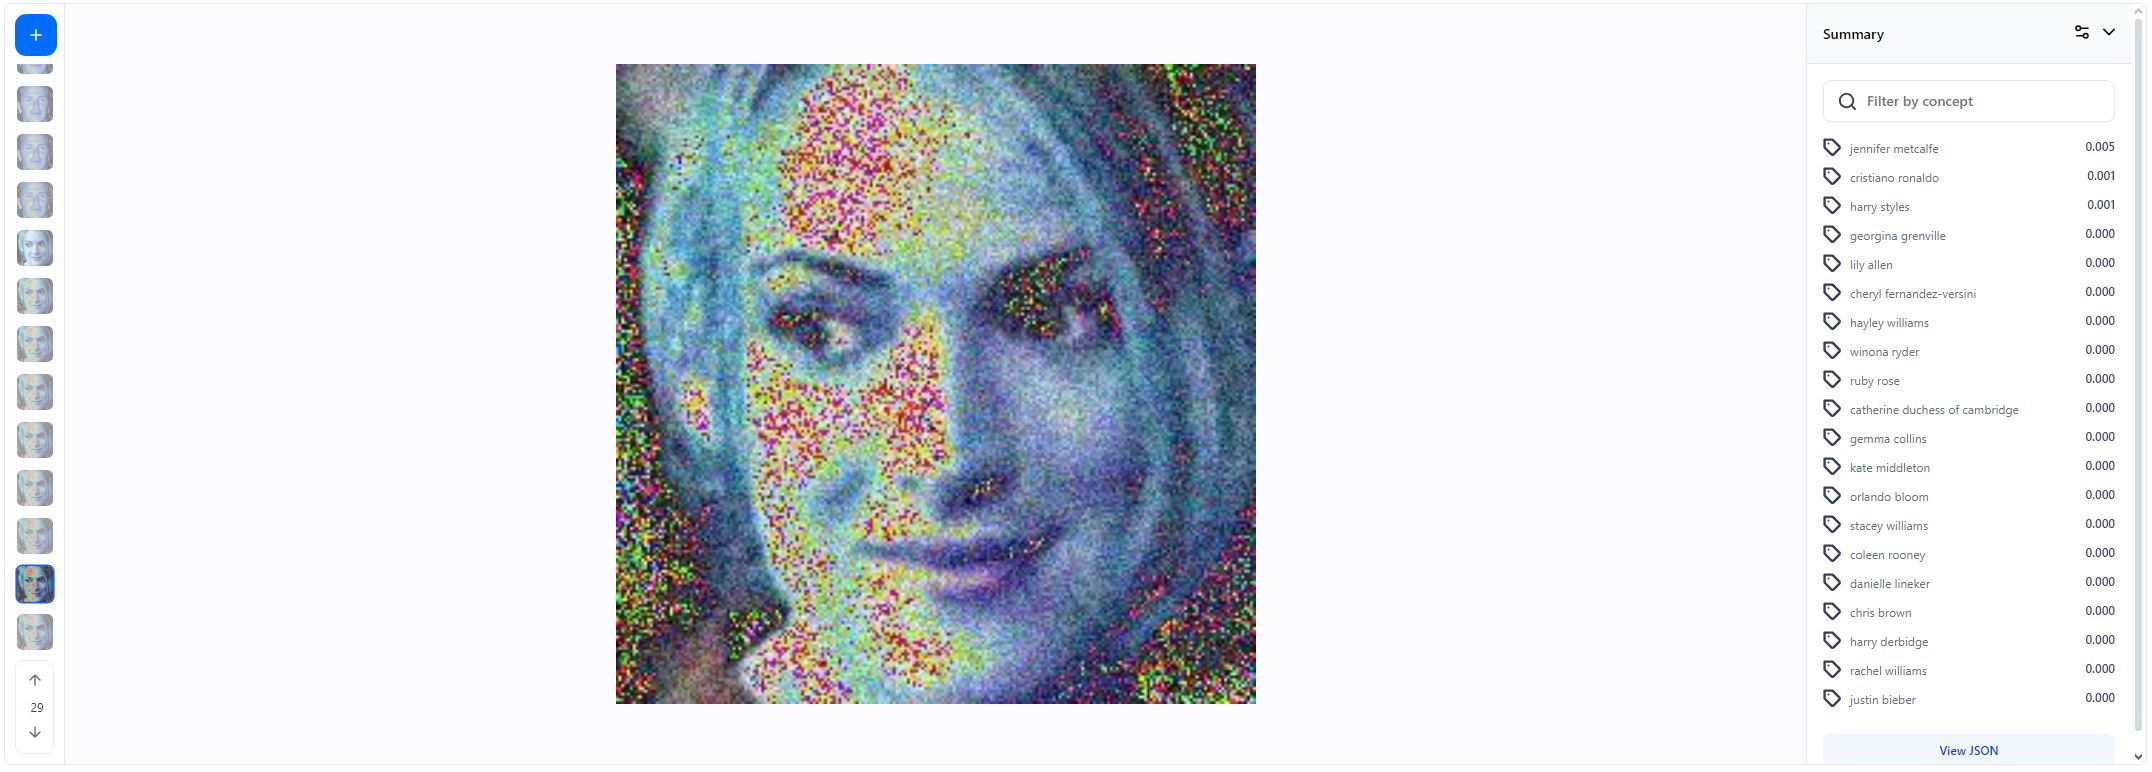

### Transferability Attack Report

For the Jennifer Lopez Pic it required a pertubation of 60/255 for it to be misclassified. For the David Beckham Pic it only required a pertubation of 35/255 to be misclassified. For the Winona Ryder Pic it required a pertubation of 50/255 to be misclassified. The model does a pretty good job of seeing through the noise added. It took awhile to find the minimum for both Jennifer Lopez and Winona Ryder, while the main reason it was so quick for David Beckham was because I started under the assumption that it would need a similar level as Jennifer Lopez.